In [1]:
import rasterio as rio
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gp
import re
from tqdm import tqdm
import os
import cv2
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from scipy.interpolate import UnivariateSpline
from scipy.spatial import ConvexHull
import seaborn as sns
from matplotlib.colors import Normalize
import matplotlib.cm as cm

In [2]:
%cd /scratch/user/anshulya
%ls

/scratch/user/anshulya
237/                             hls_data/
383_LAKE_MEAD.tif                hls_job1.sh
800_res.geojson                  hls_job2.sh
DAACDataDownload.py              hls_job3.sh
LAKE_MEAD_dem.tif                hls_job4.sh
PIP_CACHE/                       in-situ_data.csv
WT_432.geojson                   jrc_data/
area_estimation_driver.sh*       jupyter_notebooks/
area_job1.sh                     lake_rf_new.pkl
blitz_script_1.sh*               lake_rf_new_L30.pkl
blitz_script_2.sh*               log_files/
blitz_script_3.sh*               max_117.csv
blitz_script_4.sh*               max_232.csv
blitz_script_5.sh*               max_237.csv
blitz_script_6.sh*               max_264.csv
clipped_data_creation.py         max_265.csv
clipped_raster.tif               max_267.csv
compare_stats.py                 max_352.csv
cubesat_data/                    max_362.csv
cubesat_rf.pkl                   max_371.csv
delete_folders.sh*               max_394.csv
estimate_area

In [3]:
def preprocess_reservoir_shp(fname):
  reservoirs = gp.read_file(fname)

  reservoirs.loc[107,'name'] = 'Farmer_s Creek Reservoir'

  t = ['/' in s for s in reservoirs['name']]
  i = 0
  res_names = ['Cox Lake', 'Eagle Nest Lake_Manor Lake', 'Lake Ballinger_Lake Moonen', 'Lake Olney_Lake Cooper', 'Mustang Lake']
  for res_idx in [77, 93, 183, 249, 313]:
    reservoirs.loc[res_idx, 'name'] = res_names[i]
    i = i + 1

  i = 0
  res_names = ['Lake Gonzales','Clear Lake Wa']
  for res_idx in [218, 70]:
    reservoirs.loc[res_idx, 'name'] = res_names[i]
    i = i + 1

  for i in range(809):
    string = reservoirs.loc[i, 'name']
    regex = re.compile('[@!#$%^&*()<>?/\|}{~]')
    # Pass the string in search
    # method of regex object.
    if(regex.search(string) == None):
      continue
    else:
      print(i,string)

  return reservoirs

In [4]:
## Get reservoir shapefile and geometry
fname = '800_res.geojson'
reservoirs = preprocess_reservoir_shp(fname)
for idx, row in reservoirs.iterrows():
    lat = row['geometry'].centroid.y
    area = row['geometry'].area*111*111*np.cos(lat/180*np.pi)
    reservoirs.loc[idx,'area'] = area

In [5]:
sed_lakes = ['Pishkun','Nelson','Lovewell','Lake Thunderbird','Lake Estes','Lake Altus','Keith Sebelius Lake','Jamestown','Lake Tschida',
             'Harry Strunk Lake','Gibson','Fresno','Flatiron Reservoir','Edward Arthur Patterson','Calamus Reservoir','Box Butte','Bonny',
             'Belle Fourche','Lake Sumner','Heron','Elephant Butte Reservoir']

for sl in sed_lakes:
  print(sl, reservoirs[reservoirs['name']==sl].index.values[0],reservoirs[reservoirs['name']==sl]['lake_area'].values[0])

Pishkun 340 6.02
Nelson 316 14.01
Lovewell 292 8.32
Lake Thunderbird 268 20.52
Lake Estes 212 0.55
Lake Altus 176 20.44
Keith Sebelius Lake 167 5.69
Jamestown 158 7.35
Lake Tschida 270 10.41
Harry Strunk Lake 134 5.54
Gibson 124 3.91
Fresno 119 11.26
Flatiron Reservoir 110 0.17
Edward Arthur Patterson 99 1.83
Calamus Reservoir 49 18.07
Box Butte 33 3.64
Bonny 32 6.76
Belle Fourche 20 28.89
Lake Sumner 389 6.48
Heron 138 23.09
Elephant Butte Reservoir 100 110.37


In [6]:
res_idx = 237
if pd.isna(reservoirs.loc[res_idx,'grand_id']) or reservoirs.loc[res_idx,'grand_id']==-999:
    im_name = str(0) + '_' + reservoirs.loc[res_idx,'name'].replace(" ", "_")
else:
    im_name = str(int(reservoirs.loc[res_idx,'grand_id'])) + '_' + reservoirs.loc[res_idx,'name'].replace(" ", "_")
gdf = reservoirs.loc[[res_idx]]
gdf['geometry'] = gdf['geometry'].buffer(0.005)

/tmp/job.471071/ipykernel_1612495/3785019060.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(0.005)


<Axes: >

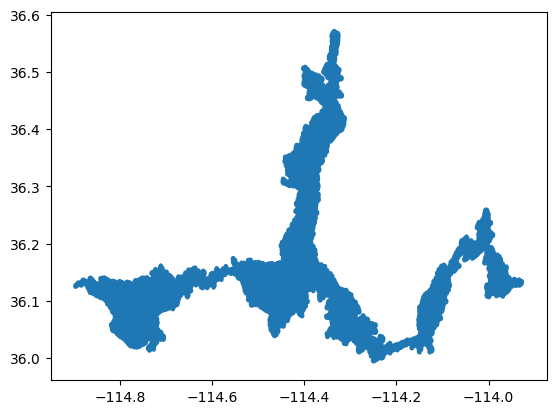

In [7]:
gdf.plot()

In [8]:
lake_area = pd.read_csv(str(res_idx)+'_f.csv')
lake_area['datetime'] = pd.to_datetime(lake_area['datetime'])
lake_area

,Unnamed: 0,date,terrain_area,enh_area1,enh_area2,threshold,elbow,cloud_cover,ice_cover,datetime,days,smoothed,sm_diff_max,rolling_std,lake_area
0,532,2016016,22.2417,304.0551,320.7069,97,90,85.686686,NaN,2016-01-16,-21,320.025235,0.000000,3.200252,320.7069
1,556,2016025,61.8534,316.8414,359.1261,96,70,78.487313,NaN,2016-01-25,-12,320.025235,0.000000,3.200252,316.8414
2,619,2016048,149.7132,313.7607,337.0824,97,80,73.623797,NaN,2016-02-17,11,320.025235,0.000000,3.200252,313.7607
3,1049,2016048,146.1051,308.0268,322.7427,97,87,73.727481,NaN,2016-02-17,11,320.025235,0.000000,3.200252,322.7427
4,467,2016057,55.9665,313.9074,365.5161,96,67,78.810286,NaN,2016-02-26,20,320.025235,0.000000,3.200252,313.9074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,957,2023267,290.1618,290.1618,290.1618,-1,-1,0.033353,0.041889,2023-09-24,2787,286.494713,0.335616,2.864947,290.1618
557,1105,2023283,296.5545,296.5545,296.5545,-1,-1,0.000000,0.045051,2023-10-10,2803,291.864568,0.671232,2.918646,296.5545
558,895,2023291,297.9009,297.9009,297.9009,-1,-1,0.000000,0.030508,2023-10-18,2811,297.234424,0.000000,2.972344,297.9009
559,1063,2023299,269.2323,301.7691,311.2578,98,90,26.339700,NaN,2023-10-26,2819,297.234424,0.000000,2.972344,301.7691


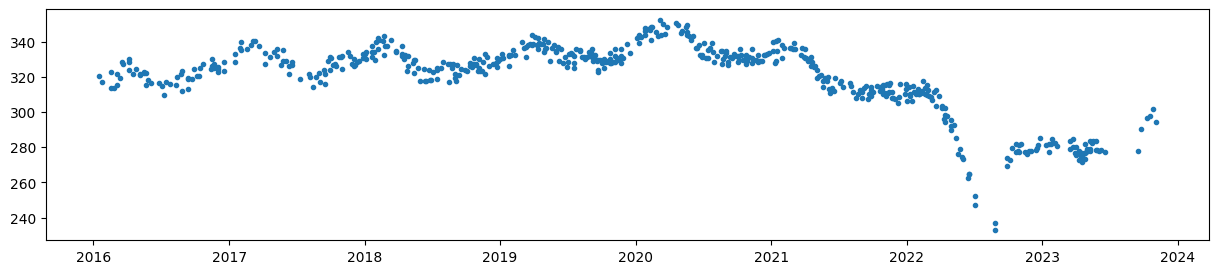

In [9]:
plt.figure(figsize=(15,3))
plt.plot(lake_area['datetime'], lake_area['lake_area'],'.')
plt.show()

In [10]:
df = lake_area[(lake_area['lake_area']>0)&(lake_area['cloud_cover']<100)]
df

,Unnamed: 0,date,terrain_area,enh_area1,enh_area2,threshold,elbow,cloud_cover,ice_cover,datetime,days,smoothed,sm_diff_max,rolling_std,lake_area
0,532,2016016,22.2417,304.0551,320.7069,97,90,85.686686,NaN,2016-01-16,-21,320.025235,0.000000,3.200252,320.7069
1,556,2016025,61.8534,316.8414,359.1261,96,70,78.487313,NaN,2016-01-25,-12,320.025235,0.000000,3.200252,316.8414
2,619,2016048,149.7132,313.7607,337.0824,97,80,73.623797,NaN,2016-02-17,11,320.025235,0.000000,3.200252,313.7607
3,1049,2016048,146.1051,308.0268,322.7427,97,87,73.727481,NaN,2016-02-17,11,320.025235,0.000000,3.200252,322.7427
4,467,2016057,55.9665,313.9074,365.5161,96,67,78.810286,NaN,2016-02-26,20,320.025235,0.000000,3.200252,313.9074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,957,2023267,290.1618,290.1618,290.1618,-1,-1,0.033353,0.041889,2023-09-24,2787,286.494713,0.335616,2.864947,290.1618
557,1105,2023283,296.5545,296.5545,296.5545,-1,-1,0.000000,0.045051,2023-10-10,2803,291.864568,0.671232,2.918646,296.5545
558,895,2023291,297.9009,297.9009,297.9009,-1,-1,0.000000,0.030508,2023-10-18,2811,297.234424,0.000000,2.972344,297.9009
559,1063,2023299,269.2323,301.7691,311.2578,98,90,26.339700,NaN,2023-10-26,2819,297.234424,0.000000,2.972344,301.7691


In [11]:
def histogram_equalization(matrix):
    # Scale matrix values from [0, 1] to [0, 255]
    scaled_matrix = np.clip((matrix * 255), 0, 255).astype(int)
    
    # Calculate histogram
    hist, bins = np.histogram(scaled_matrix.flatten(), 256, [0,256])
    
    # Calculate cumulative distribution function (CDF)
    cdf = hist.cumsum()
    
    # Mask all zeros and get the minimum (excluding 0)
    cdf_m = np.ma.masked_equal(cdf, 0)
    
    # Equalize
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    
    # Fill masked places with 0
    cdf = np.ma.filled(cdf_m, 0).astype('uint8')
    
    # Map the equalized values to the scaled matrix
    equalized_scaled_matrix = cdf[scaled_matrix]
    
    # Optionally, scale back to [0, 1] range
    equalized_matrix = equalized_scaled_matrix / 255.0
    
    return equalized_matrix

In [12]:
def get_bit(number, bit_position):
    return (number >> bit_position) & 1

def matrix_get_bit(matrix, bit_position):
    matrix = matrix.astype(int)  # Ensure matrix elements are integers
    vec_get_bit = np.vectorize(get_bit)
    return vec_get_bit(matrix, bit_position)

In [13]:
new_df = df.dropna(subset=['lake_area']).copy()

# If you want to reset the index of the new DataFrame
new_df.reset_index(drop=True, inplace=True)

In [14]:
in_situ = pd.read_csv('in-situ_data.csv')

In [15]:
mask = in_situ['RES_NAME'].str.lower().apply(lambda x: any(lake.lower() in x for lake in [reservoirs.loc[res_idx,'name']]))
df2 = in_situ[mask]
df2 = in_situ[in_situ['RES_NAME']=='LAKE MEAD']
df2['datetime'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')
df2.head()

/tmp/job.471071/ipykernel_1612495/983012349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['datetime'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')


,Unnamed: 0,RES_NAME,date,stage_m,area_m2,depth_m,datum,qflag,datetime
50142,50142,LAKE MEAD,2016-01-01,329.491848,3.369055e+08,36.959124,RPVD,O,2016-01-01
50143,50143,LAKE MEAD,2016-01-02,329.528424,3.370734e+08,36.977316,RPVD,O,2016-01-02
50144,50144,LAKE MEAD,2016-01-03,329.558904,3.372132e+08,36.992706,RPVD,O,2016-01-03
50145,50145,LAKE MEAD,2016-01-04,329.568048,3.372552e+08,36.997247,RPVD,O,2016-01-04
50146,50146,LAKE MEAD,2016-01-05,329.613768,3.374650e+08,37.019936,RPVD,O,2016-01-05


In [17]:
# Assuming res_idx and new_df are already defined
directory_path = os.path.join(str(res_idx), 'classified_rasters', str(new_df.iloc[42,1]))
all_files = os.listdir(directory_path)

# Initialize the variable to None which will hold the name of the desired file
sat = None

# Loop through all the files in the directory
for file in all_files:
    # Check if the file name is not equal to 'tile_metadata.csv'
    if file != 'tile_metadata.csv':
        # If it's not, set desired_file to the name of this file and break out of the loop
        sat = file
        break

FileNotFoundError: [Errno 2] No such file or directory: '237/classified_rasters/2016317'

In [ ]:
print(directory_path)
print(all_files)
print(sat)

In [16]:
jrc = rio.open(os.path.join(str(res_idx), 'clipped_rasters', str(new_df.loc[42,'date']), sat, 'jrc.tif')).read(1).astype('float')

NameError: name 'sat' is not defined

In [ ]:
plt.imshow(jrc)

In [ ]:
full_area = jrc[jrc>0].shape[0]*900/10**6

In [18]:
merged_df = pd.merge(new_df, df2, on='datetime', how='inner')
merged_df['difference'] = merged_df['area_m2']/10**6 - merged_df['lake_area']

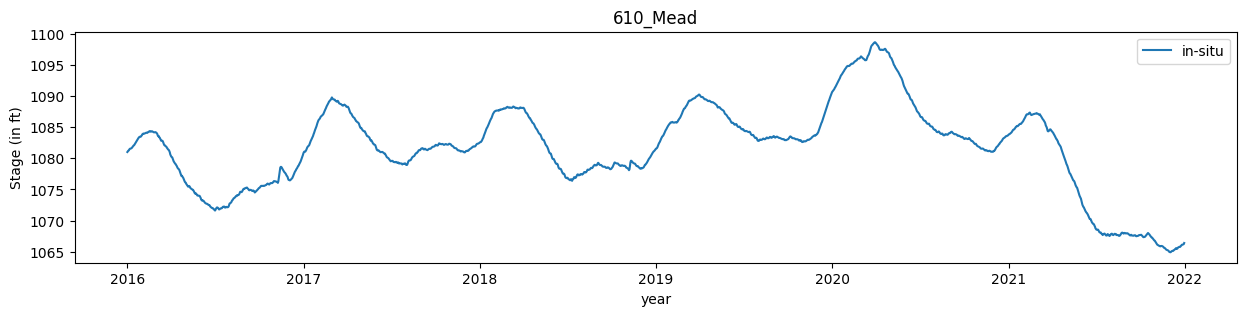

In [19]:
plt.figure(figsize=(15,3))
plt.plot(df2['datetime'], df2['stage_m']*3.28084,label='in-situ')
plt.xlabel('year')
plt.ylabel('Stage (in ft)')
plt.title(im_name)
plt.legend()
plt.show()

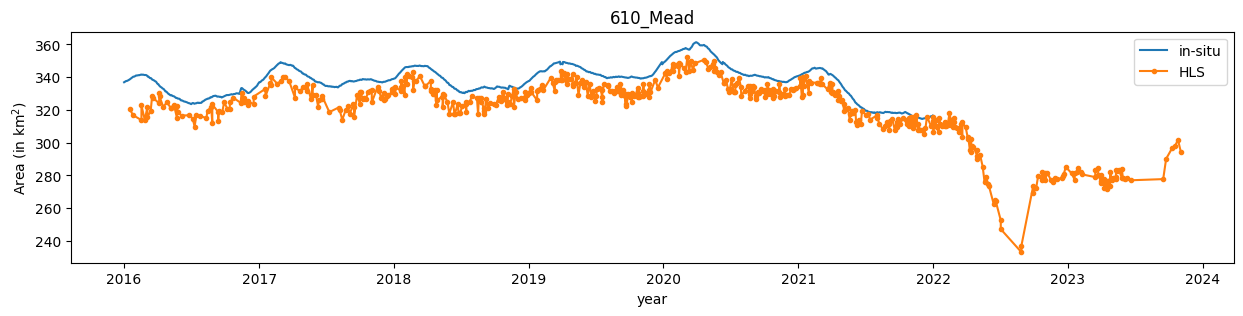

In [20]:
plt.figure(figsize=(15,3))
plt.plot(df2['datetime'], df2['area_m2']/10**6,label='in-situ')
# plt.plot(df2['datetime'], (df2['stage_m']-263.26)/0.20,label='in-situ corrected')
plt.plot(new_df['datetime'], new_df['lake_area'],'.-',label='HLS')

# plt.plot(merged_df['datetime'],np.absolute(merged_df['area_m2']/10**6 - merged_df['lake_area']),label='absolute difference')
# plt.axhline(y=0,color='k',linestyle='--')
# plt.axhline(y=full_area,color='r',linestyle='--',label='max extent')
plt.xlabel('year')
plt.ylabel('Area (in km$^2$)')
plt.title(im_name)
plt.legend()
plt.show()

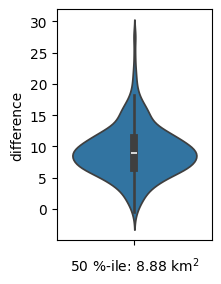

In [21]:
q1 = np.percentile(merged_df['difference'], 50)
q2 = np.percentile(merged_df['difference'], 75)
plt.figure(figsize=(2,3))
sns.violinplot(merged_df['difference'])
plt.xlabel(f'50 %-ile: {q1:.2f} km$^2$')
plt.show()

In [22]:
from io import StringIO

In [23]:
# Provided CSV data
csv_data = """elevation,OriginalSurvey,OriginalCapacity,1947-48Survey,1947-48SurveyCapacity,1963-64Survey,1963-64SurveyCapacity,2001Survey,2001SurveyCapacity,SedimentSurvey,SedimentSurveyCapacity,SedimentOrig-1964,SedimentOrig-2001,Sediment1963-2001,PercentTotal,PercentTotalReservoir
1229.0,162585,32381780,162677,31047000,162608,29759860,162548,29979010,2621920,2402770,-219150,100.0,100.0,100.0
1220.0,156834,30944400,157736,29606000,157073,28321300,156473,28543420,2623100,2400980,-222120,100.0,99.9,98.4
1219.6,156613,30881710,156839,29458000,156839,28258510,156250,28480870,2623200,2400840,-222360,100.0,99.9,98.4
1200.0,145240,27920820,145100,26583000,144892,25299240,143563,25534050,2621580,2386770,-234810,100.0,99.3,95.0
1175.0,131962,24460420,128960,23152000,128960,21871640,123487,22201990,2588780,2258430,-330350,98.7,94.0,90.7
1150.0,119448,21318380,115500,20103000,111551,18861810,111056,19278840,2456570,2039540,-417030,93.7,84.9,86.4
1125.0,108232,18477620,99540,17350000,99540,16232550,99663,16654230,2245070,1823390,-421680,85.6,75.9,82.0
1100.0,97833,15901810,94700,14852000,89471,13872210,89814,14284400,2029600,1617410,-412190,77.4,67.3,77.7
1083.0,91006,14295850,83261,13297000,83261,12405420,83902,12807630,1890430,1488220,-402210,72.1,61.9,74.8
1075.0,87833,13580720,80431,12604000,80431,11750510,81148,12147520,1830210,1433200,-397010,69.8,59.6,73.4
1050.0,77895,11508640,75400,10594000,71160,9852651,72208,10229410,1655989,1279230,-376759,63.2,53.2,69.1
1025.0,68941,9675114,62712,8822000,62712,8183496,64078,8527654,1491618,1147460,-344158,56.9,47.8,64.8
1000.0,60528,8055581,58300,7262000,54816,6712890,56374,7021833,1342691,1033748,-308943,51.2,43.0,60.4
975.0,52958,6637536,47898,5902000,47898,5434287,49186,5702885,1203249,934651,-268598,45.9,38.9,56.1
950.0,46427,5396458,41567,4715000,41567,4314975,42869,4552117,1081483,844341,-237142,41.2,35.1,51.8
925.0,40479,4310816,35762,3679000,35762,3349568,37063,3553325,961248,757491,-203757,36.7,31.5,47.5
900.0,34393,3373994,29950,2783000,29950,2526955,31152,2699843,847039,674151,-172888,32.3,28.1,43.2
895.0,33392,3204531,28911,2620000,28911,2379801,30172,2546532,824730,657999,-166731,31.5,27.4,42.3
875.0,29425,2576859,27000,1500000,25598,1837206,26690,1979168,739653,597691,-141962,28.2,24.9,38.9
850.0,24712,1899317,23000,1200000,21530,1246022,22540,1362705,653295,536612,-116683,24.9,22.3,34.5
825.0,19911,1345430,18000,700000,16914,767712,17905,859239,577718,486191,-91527,22.0,20.2,30.2
800.0,15530,902445,13000,400000,12326,397744,13266,467648,504701,434797,-69904,19.2,18.1,25.9
775.0,11226,572209,7500,178000,6702,178186,7566,224088,394023,348121,-45902,15.0,14.5,21.6
750.0,8185,331651,7000,42300,4151,42282,4781,69610,289369,262041,-27328,11.0,10.9,17.3
725.0,5019,176794,10,400,31,387,702,2203,176407,174591,-1816,6.7,7.3,13.0
700.0,3521,69578,0,0,0,0,0,3,69578,69575,-3,2.7,2.9,8.6
675.0,1217,11820,0,0,0,0,0,0,11820,11820,0,0.5,0.6,3.2
650.0,119,298,0,0,0,0,0,0,298,298,0,0.1,0.1,0.9"""

# Convert CSV data to pandas DataFrame
df = pd.read_csv(StringIO(csv_data))

# Calculate reservoir area
df['Area'] = (df['2001SurveyCapacity'].diff(-1) / df['elevation'].diff(-1)).abs()

df

,elevation,OriginalSurvey,OriginalCapacity,1947-48Survey,1947-48SurveyCapacity,1963-64Survey,1963-64SurveyCapacity,2001Survey,2001SurveyCapacity,SedimentSurvey,SedimentSurveyCapacity,SedimentOrig-1964,SedimentOrig-2001,Sediment1963-2001,PercentTotal,PercentTotalReservoir,Area
0,1229.0,162585,32381780,162677,31047000,162608,29759860,162548,29979010,2621920,2402770,-219150,100.0,100.0,100.0,NaN,159510.000000
1,1220.0,156834,30944400,157736,29606000,157073,28321300,156473,28543420,2623100,2400980,-222120,100.0,99.9,98.4,NaN,156375.000000
2,1219.6,156613,30881710,156839,29458000,156839,28258510,156250,28480870,2623200,2400840,-222360,100.0,99.9,98.4,NaN,150347.959184
3,1200.0,145240,27920820,145100,26583000,144892,25299240,143563,25534050,2621580,2386770,-234810,100.0,99.3,95.0,NaN,133282.400000
4,1175.0,131962,24460420,128960,23152000,128960,21871640,123487,22201990,2588780,2258430,-330350,98.7,94.0,90.7,NaN,116926.000000
5,1150.0,119448,21318380,115500,20103000,111551,18861810,111056,19278840,2456570,2039540,-417030,93.7,84.9,86.4,NaN,104984.400000
6,1125.0,108232,18477620,99540,17350000,99540,16232550,99663,16654230,2245070,1823390,-421680,85.6,75.9,82.0,NaN,94793.200000
7,1100.0,97833,15901810,94700,14852000,89471,13872210,89814,14284400,2029600,1617410,-412190,77.4,67.3,77.7,NaN,86868.823529
8,1083.0,91006,14295850,83261,13297000,83261,12405420,83902,12807630,1890430,1488220,-402210,72.1,61.9,74.8,NaN,82513.750000
9,1075.0,87833,13580720,80431,12604000,80431,11750510,81148,12147520,1830210,1433200,-397010,69.8,59.6,73.4,NaN,76724.400000


In [112]:
csv_data = """Elevation OriginalArea OriginalCapacity 2012Area 2012Capacity SedimentVolume PercentComputedSediment PercentReservoirDepth
2252.8 6,348 177,623 6,348 169530 8,093 100.0 100.0
2250.0 5,899 160,477 5,899 152384 8,093 100.0 96.6
2245.0 5,256 132,590 5,210 124611 7,979 98.6 90.6
2244.5 5,190 129,979 5,142 122023 7,956 98.3 90.0
2244.0 5,123 127,400 5,073 119469 7,931 98.0 89.4
2240.0 4,593 107,967 4,423 100493 7,474 92.4 84.5
2235.0 3,962 86,580 3,893 79765 6,815 84.2 78.5
2230.0 3,434 68,090 3,306 61804 6,286 77.7 72.5
2225.0 2,920 52,205 2,803 46539 5,666 70.0 66.4
2220.0 2,442 38,800 2,353 33675 5,125 63.3 60.4
2215.0 1,945 27,832 1,859 23181 4,651 57.5 54.3
2213.3 1,804 24,646 1,709 20150 4,496 55.6 52.3
2210.0 1,530 19,145 1,434 14968 4,177 51.6 48.3
2205.0 1,149 12,447 1,030 8798 3,649 45.1 42.3
2200.0 806 7,560 687 4,512 3048 37.7 36.2
2195.0 532 4,215 396 1,822 2393 29.6 30.2
2190.0 334 2,050 166 479 1571 19.4 24.2
2185.0 159 817 25 35 782 9.7 18.1
2181.0 88 324 0 0 324 4.0 13.3
2180.0 70 245 0 0 245 3.0 12.1
2175.0 14 35 0 0 35 0.4 6.0
2170.0 0 0 0 0 0 0.0 0.0"""

# Convert CSV data to a pandas DataFrame
df = pd.read_csv(StringIO(csv_data), delim_whitespace=True)

# Calculate reservoir area
df['Area'] = (df['2012Capacity'].astype('float').diff(-1) / df['Elevation'].astype('float').diff(-1)).abs()

# Display the DataFrame
df

ValueError: could not convert string to float: '4,512'

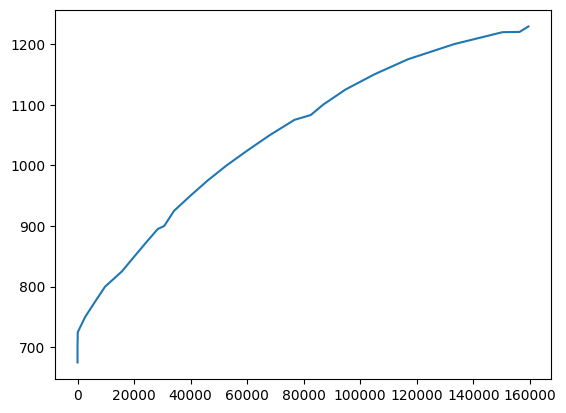

In [61]:
plt.plot(df['Area'],df['elevation'])

In [24]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [25]:
df_new = df[(df['elevation']>=1025)&(df['elevation']<=1100)]

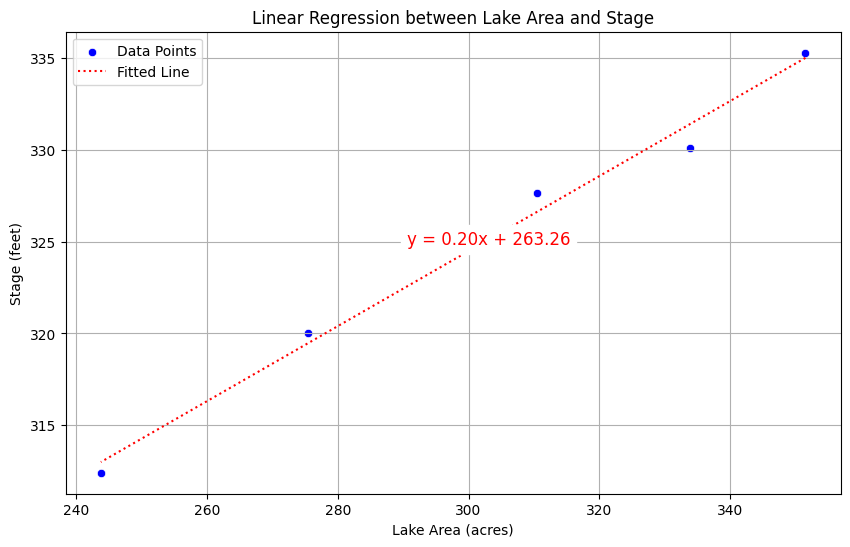

In [26]:
# Assuming merged_df is your DataFrame
X = (merged_df['lake_area']).values.reshape(-1, 1)  # Independent variable
y = (merged_df['stage_m']).values  # Dependent variable

# X = (merged_df['area_m2']/10**6).values.reshape(-1, 1)  # Independent variable
# y = (merged_df['stage_m']).values  # Dependent variable

X = (df_new['Area']*0.00404686).values.reshape(-1, 1)  # Independent variable
y = (df_new['elevation']*0.3048).values  # Dependent variable

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the slope (coefficient) and intercept of the fitted line
slope = model.coef_[0]
intercept = model.intercept_

# Scatter plot and linear regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X.squeeze(), y=y, color='blue', label='Data Points')
plt.plot(X, model.predict(X), linestyle='dotted', color='red', label='Fitted Line')

# Display the line equation
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
plt.text(np.mean(X), np.mean(y), line_eq, fontsize=12, va='center', ha='center', backgroundcolor='white', color='red')

# Labeling the axes and title
plt.xlabel('Lake Area (acres)')
plt.ylabel('Stage (feet)')
plt.title('Linear Regression between Lake Area and Stage')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
df_sed = merged_df[merged_df['cloud_cover']<5]

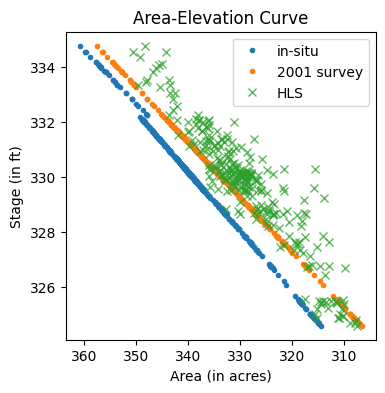

In [36]:
plt.figure(figsize=(4,4))
plt.plot(merged_df['area_m2']/10**6, merged_df['stage_m'],'.',label='in-situ')

# plt.plot(df_new['Area'],df_new['elevation'])
plt.plot((merged_df['stage_m']-263.26)/0.20,merged_df['stage_m'],'.',label='2001 survey')
plt.plot(df_sed['lake_area'], df_sed['stage_m'],'x',alpha=0.75,label='HLS')
plt.ylabel('Stage (in ft)')
plt.xlabel('Area (in acres)')
plt.title('Area-Elevation Curve')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [80]:
def find_threshold_for_count(matrix, area):

    if area>matrix[matrix>=1].shape[0]*900/10**6:
        return 1
    
    # Convert the matrix to a NumPy array for efficient operations
    matrix_array = np.array(matrix)
    
    # Sort the flattened matrix in descending order
    sorted_values = np.sort(matrix_array.flatten())[::-1]

    desired_count = int(area*10**6/900)
    
    # Find the threshold value
    threshold = sorted_values[desired_count - 1]  # Subtract 1 to account for 0-based indexing
    
    return threshold

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


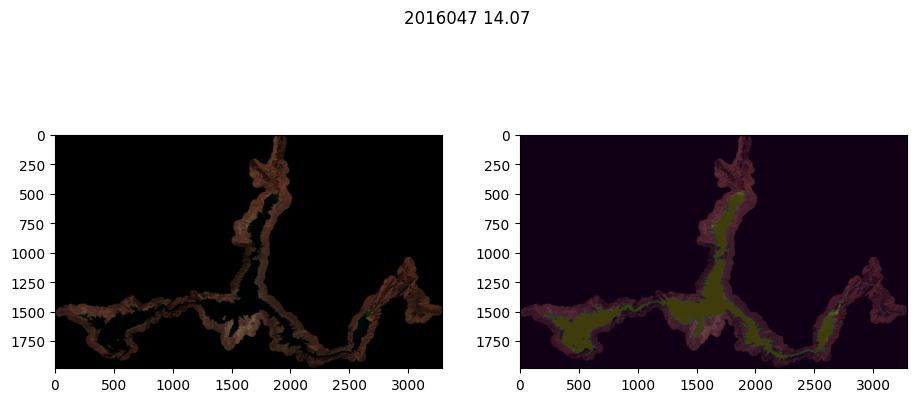

In [82]:
for idx, row in merged_df[(merged_df['difference']>q2)&(merged_df['cloud_cover']<10)].iterrows():
    try:
        try:
            sat = os.listdir(os.path.join(str(res_idx),'classified_rasters',str(row['date_x'])))[0]
        except:
            continue
    
        if sat == 'L30':
            b = '05'
        else:
            b = '8A'
        
        raw = np.load(os.path.join(str(res_idx),'classified_rasters',str(row['date_x']),sat,'terrain.npy'))
        enh = np.load(os.path.join(str(res_idx),'classified_rasters',str(row['date_x']),sat,'enhanced1.npy'))
    
        R = rio.open(os.path.join(str(res_idx),'clipped_rasters',str(row['date_x']),sat, 'B'+b+'_stitched_raster.tif')).read(1).astype('float')*0.0001
        R[R==-9999*0.0001] = 0
        G = rio.open(os.path.join(str(res_idx),'clipped_rasters',str(row['date_x']),sat, 'B03_stitched_raster.tif')).read(1).astype('float')*0.0001
        G[G==-9999*0.0001] = 0
        B = rio.open(os.path.join(str(res_idx),'clipped_rasters',str(row['date_x']),sat, 'B02_stitched_raster.tif')).read(1).astype('float')*0.0001
        B[B==-9999*0.0001] = 0
    
    
        fmask = rio.open(os.path.join(str(res_idx),'clipped_rasters',str(row['date_x']),sat,'Fmask_stitched_raster.tif')).read(1).astype('int')
    
        cloud_mask = matrix_get_bit(fmask, 1)
        water_mask = matrix_get_bit(fmask, 5)
        ice_mask = matrix_get_bit(fmask, 4)
    
        raw_cloud = raw.copy()
        raw_cloud[(cloud_mask==1)&(raw_cloud!=1)] = 2
        raw_cloud[(water_mask==1)] = 1
        raw_cloud[ice_mask==1] = 3
    
        # w_frac = (raw_cloud[raw_cloud==1]).shape[0]/(raw[raw==1]).shape[0]
    
        # if w_frac>1.4:
        #     raw_cloud = raw.copy()
        #     raw_cloud[(cloud_mask==1)&(raw_cloud!=1)] = 2
        #     raw_cloud[ice_mask==1] = 3
    
        thr = find_threshold_for_count(jrc, row['area_m2']/10**6)

        
            
    
        fig, ax = plt.subplots(1,2,figsize=(11,5))
        fig.suptitle(str(row['date_x']) + ' ' + '{:.2f}'.format(row['difference']))
        ax[0].imshow(np.dstack((R,G,B)))
        # ax[1].imshow(np.dstack((R,G,B)))
        # ax[1].imshow(enh, alpha=0.5)
        # ax[2].imshow(np.dstack((R,G,B)))
        # ax[2].imshow(raw_cloud, alpha=0.5)
        ax[1].imshow((jrc>=thr))
        ax[1].imshow(np.dstack((R,G,B)), alpha=0.75)

        if thr == 1:
            fig.suptitle(str(row['date_x']) + ' ' + '{:.2f}'.format(row['difference']) + ' max extent')
        plt.show()
        break
    except KeyboardInterrupt:
        break
    except:
        continue

## Yearwise change in JRC curve

In [114]:
# water_correction = []
# for idx, row in df.iterrows():
#     try:
#         sat = os.listdir(os.path.join(str(res_idx),'classified_rasters',str(row['date'])))[0]
#     except:
#         continue

#     if sat == 'L30':
#         b = '05'
#     else:
#         b = '8A'
    
#     raw = np.load(os.path.join(str(res_idx),'classified_rasters',str(row['date']),sat,'terrain.npy'))
#     enh = np.load(os.path.join(str(res_idx),'classified_rasters',str(row['date']),sat,'enhanced1.npy'))

#     R = rio.open(os.path.join(str(res_idx),'clipped_rasters',str(row['date']),sat, 'B'+b+'_stitched_raster.tif')).read(1).astype('float')*0.0001
#     R[R==-9999*0.0001] = 0

    
#     G = rio.open(os.path.join(str(res_idx),'clipped_rasters',str(row['date']),sat, 'B03_stitched_raster.tif')).read(1).astype('float')*0.0001
#     G[G==-9999*0.0001] = 0

    
#     B = rio.open(os.path.join(str(res_idx),'clipped_rasters',str(row['date']),sat, 'B02_stitched_raster.tif')).read(1).astype('float')*0.0001
#     B[B==-9999*0.0001] = 0


#     fmask = rio.open(os.path.join(str(res_idx),'clipped_rasters',str(row['date']),sat,'Fmask_stitched_raster.tif')).read(1).astype('int')

#     cloud_mask = matrix_get_bit(fmask, 1)
#     water_mask = matrix_get_bit(fmask, 5)
#     ice_mask = matrix_get_bit(fmask, 4)

#     raw_cloud = raw.copy()
#     raw_cloud[(cloud_mask==1)&(raw_cloud!=1)] = 2
#     raw_cloud[(water_mask==1)] = 1
#     raw_cloud[ice_mask==1] = 3

#     w_frac = (raw_cloud[raw_cloud==1]).shape[0]/(raw[raw==1]).shape[0]

#     if w_frac>1.4:
#         raw_cloud = raw.copy()
#         raw_cloud[(cloud_mask==1)&(raw_cloud!=1)] = 2
#         raw_cloud[ice_mask==1] = 3
        

#     fig, ax = plt.subplots(1,4,figsize=(15,5))
#     fig.suptitle(str(row['date']) + ' ' + '{:.2f}'.format(w_frac))
#     ax[0].imshow(raw)
#     ax[1].imshow(enh)
#     ax[2].imshow(raw_cloud)
#     ax[3].imshow(np.dstack((R,G,B)))
#     plt.show()

#     water_correction.append(w_frac)
    

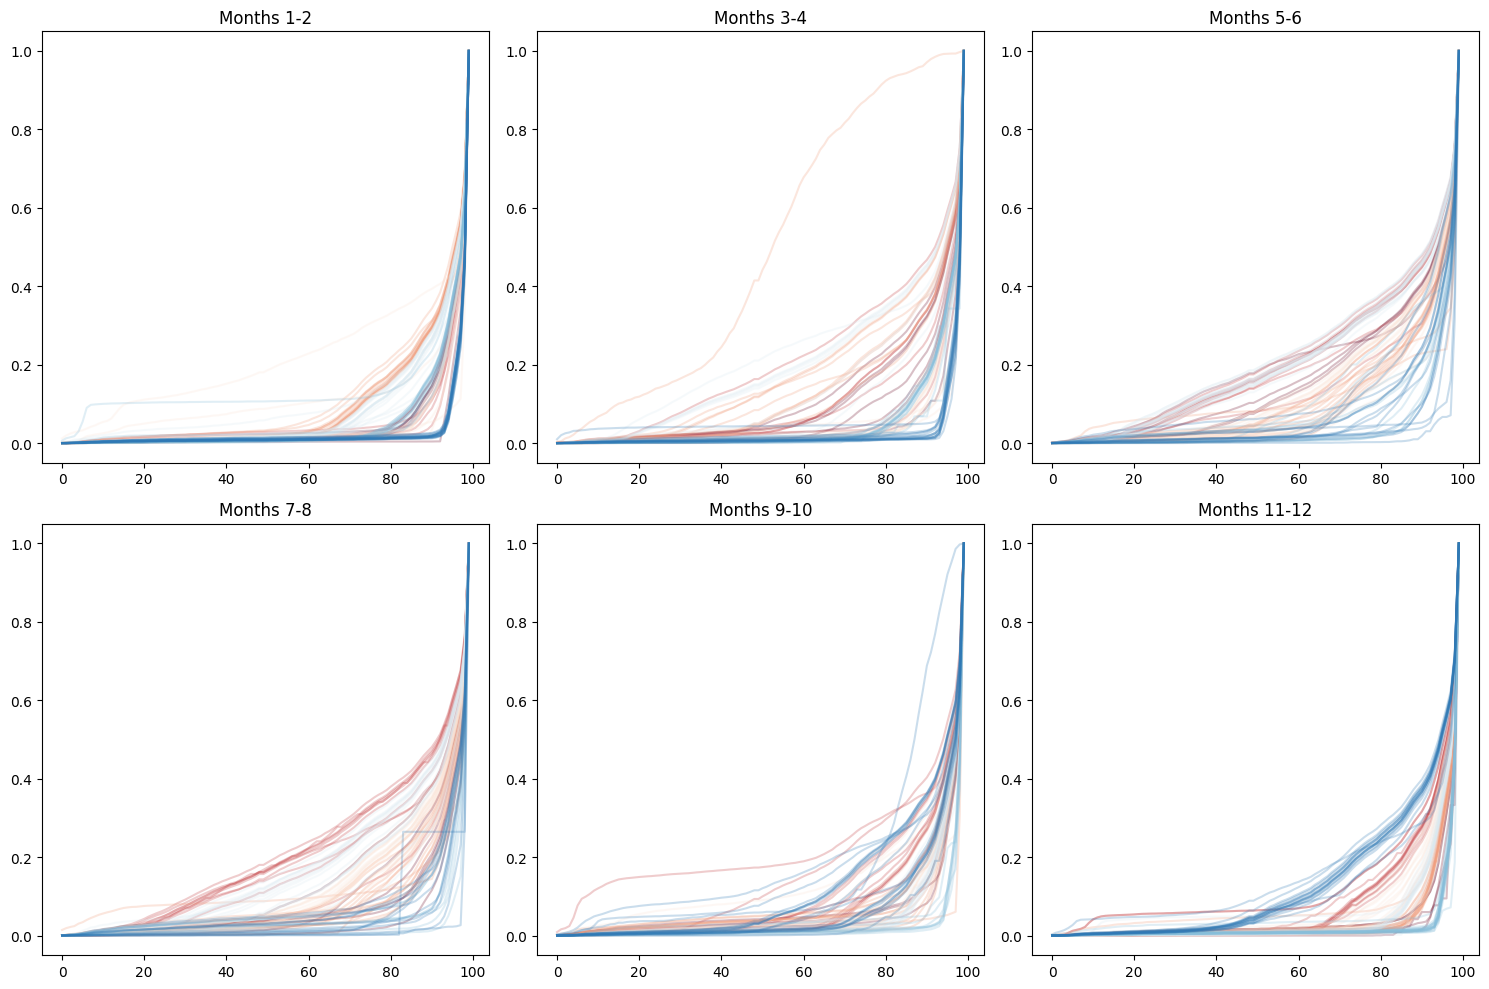

In [115]:
# Create 2x3 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()  # Flatten the 2D array to 1D for easier indexing

# Define a colormap and a normalization based on the year range
colormap = cm.RdBu
norm = Normalize(vmin=2016, vmax=2023)

# Loop through the DataFrame
for idx, row in df.iterrows():
    sat = os.listdir(os.path.join(str(res_idx), 'classified_rasters', str(row['date'])))[0]
    
    raw = np.load(os.path.join(str(res_idx), 'classified_rasters', str(row['date']), sat, 'enhanced1.npy'))
    jrc = rio.open(os.path.join(str(res_idx), 'clipped_rasters', str(row['date']), sat, 'jrc.tif')).read(1).astype('float')

    data = jrc[raw == 1]
    # Compute the histogram
    hist, bins = np.histogram(data, bins=100, density=True)
    # Compute the CDF
    cdf = np.cumsum(hist) * (bins[1] - bins[0])  # Multiply by bin width to ensure the CDF goes to 1

    # Extract the month and year from row['date']
    date_str = str(row['date'])
    date_obj = datetime.strptime(date_str, '%Y%j')
    month = date_obj.month
    year = date_obj.year
    
    # Determine the subplot index based on the month
    subplot_idx = (month - 1) // 2  # Integer division to group two months together
    
    # Get color based on the year
    plot_color = colormap(norm(year))
    
    # Plot the CDF in the corresponding subplot with the selected color
    axs[subplot_idx].plot(cdf, color=plot_color, alpha=0.25)
    axs[subplot_idx].set_title(f'Months {subplot_idx*2 + 1}-{subplot_idx*2 + 2}')
    
# Adjust layout and show the plots
plt.tight_layout()
plt.show()